In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, PreTrainedTokenizerFast, DataCollatorForLanguageModeling
import torch
import torch.nn as nn
import sys
import numpy as np
sys.path.append("../VAE_standard")
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE

from matplotlib import pyplot as plt

sys.path.append("..")
import utils

import Bio.Data.CodonTable

from devinterp.utils import (
    EvaluateFn,
    EvalResults,
)

from BIF_sampler import (
    BIFEstimator,
    estimate_bif
)

import copy
from ex1_AA_influence import (
    get_BIF_data, 
    disp_BIF_influence
)

## Data preparation/Loading ESM model

In [2]:
MAX_TOKEN_LENGTH = 510
BATCH_SIZE=60
num_masks = 3

TEST_SEQ = 10
TRAIN_CUTOFF = 3000
TEST_TOKEN = 3

DEVICE = "cuda"

In [3]:
"""
tokenizer: 
input_ids - torch.LongTensor of shape (batch_size, sequence_length)
attention_mask - torch.Tensor of shape (batch_size, sequence_length), Mask values selected in {0,1}, where 0 := masked, 1 := not masked
"""

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D").to(DEVICE)

/home/averma2/miniforge3/envs/Moreta_env/lib/python3.9/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
data_dict = get_BIF_data(tokenizer, 
                        MAX_TOKEN_LENGTH=MAX_TOKEN_LENGTH, 
                        BATCH_SIZE=BATCH_SIZE, 
                        num_masks=num_masks,
                        TEST_SEQ=TEST_SEQ, 
                        TRAIN_CUTOFF=TRAIN_CUTOFF,
                        TEST_TOKEN=TEST_TOKEN,
                        DEVICE=DEVICE)

bif_dataloader = data_dict["bif_dataloader"]
sgld_dataloader = data_dict["sgld_dataloader"]
test_seq = data_dict["test_seq"]
test_seq_label = data_dict["test_seq_label"]
test_seq_disp = data_dict["test_seq_disp"]

MAX_TOKEN_LENGTH=510
BATCH_SIZE=60
num_masks=3
TEST_SEQ=10
TRAIN_CUTOFF=3000
TEST_TOKEN=3
DEVICE=cuda
done extracting sequences!
done extracting AAs!
done creating element copies!
done creating bif masks!
done creating bif labels!
done creating sgld dataset!
masked seqs len: 170
length train data: 3000
SGLD inputs, labels
torch.Size([3000, 510])
torch.Size([3000, 510]) 

BIF inputs, labels
torch.Size([170, 510])
torch.Size([170, 510]) 



## Per-token BIF algorithm
<img src="./per_tok_BIF.png" width="1000" height="1000"/>

### For MLM models like ESM, $\ell_i(w) = -\sum_{s\in [M]}^S log(p(z_{i,s} | z_{i,[M]^c}))$, where $[M]$ is random mask. Then, I define $\ell_{i,s}(w) = -log(p(z_{i,s} | z_{i,\{s\}^c}))$, i.e. the loss of a single token is the cross-entropy loss of masking that single token

### Define sequences $\{x_i\}_{i=1}^N$ where $x_i = (x_{i,1},...x_{i,S})$ and $S:=$length of sequence. Then, I fix one amino-acid $x_{i,j}$ and calculate $BIF(*,x_{i,j}$)

In [14]:
def get_loss_vec(
    model,
    dataloader=bif_dataloader, 
    vocab_size=tokenizer.vocab_size, 
    num_data = MAX_TOKEN_LENGTH // num_masks,
    batch_size = BATCH_SIZE
):
    """
    dataloader: (torch.utils.DataLoader) where each element is of the form ((input, attention_mask), label)
    vocab_size: number of unique tokens in tokenizer (tokenizer.vocab_size)
    model: ESM model

    returns: array of losses which is used to calculate BIF matrix
    """
    loss_vec = torch.zeros(num_data).to(DEVICE)
    with torch.no_grad():
        for i, ((test_input, test_mask), test_labels) in enumerate(dataloader):
            bsize = test_input.shape[0]
            outputs = model(test_input, attention_mask=test_mask)["logits"] # returns tensor of size (batch, seq_length, vocab_size)
            batch_loss = torch.sum(nn.functional.cross_entropy(outputs.view(-1,vocab_size), target=test_labels.view(-1), ignore_index=-100, reduction="none").view(bsize, -1), dim=-1)
            if i < len(dataloader) - 1:
                loss_vec[i * batch_size : (i+1) * batch_size] = batch_loss
            else:
                loss_vec[i * batch_size:] = batch_loss
            
    return loss_vec

def get_obs(
    model,
    test_seq=((test_seq["input_ids"], test_seq["attention_mask"]), test_seq_label), 
):
    """
    test_seq: tuple of form ((input, attention_mask), label) -- attention_mask should be tensor of same length as input tensor and containing only 1s
        input has shape (1, seq_length)
        attention_mask has shape (1, seq_length)
        label has shape (seq_length)
    model: ESM model

    returns: loss value used to calculate BIF_matrix
    """
    (test_input, test_mask), test_label = test_seq
    with torch.no_grad():
        test_output = model(test_input, attention_mask=test_mask)["logits"].squeeze()
        return torch.tensor(nn.functional.cross_entropy(test_output, target=test_label, ignore_index=-100, reduction="sum").item())

In [15]:
def evaluate_function(model: nn.Module, data: torch.Tensor, device=DEVICE) -> EvalResults:
    """
    model (torch.nn.module): ESM model
    data (torch.Tensor): minibatch data used to update weights of model in SGLD
    device (String): either "cuda" or "cpu"

    returns:
    dictionary with 
    (i) loss - loss used to update weights of model
    (ii) obs - calculated observables (in this case cross-entropy loss on one test token) as described above
    (iii) loss_vec - the losses evaluated at every training point for the model used to compute the BIF as described in the algorithm at the top
    """

    inputs, targets = data
    return {
        "loss": model(inputs, labels=targets).loss,
        "obs": get_obs(model=model),
        "loss_vec": get_loss_vec(model=model)
    }

## Estimating BIF on test_seq

In [16]:
ESM_BIF = estimate_bif(
    model=model,
    loader = sgld_dataloader,
    evaluate = evaluate_function,
    num_obs=1,
    device=DEVICE,
    num_chains=4,
    num_draws=50,
    num_data=MAX_TOKEN_LENGTH // num_masks
)

/home/averma2/code/devinterp/src/devinterp/backends/default/slt/sampler.py:262: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/averma2/code/devinterp/src/devinterp/backends/default/slt/sampler.py:311: UserWarning: If you're setting a nbeta or temperature in sampling_method_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
Chain 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.92it/s]


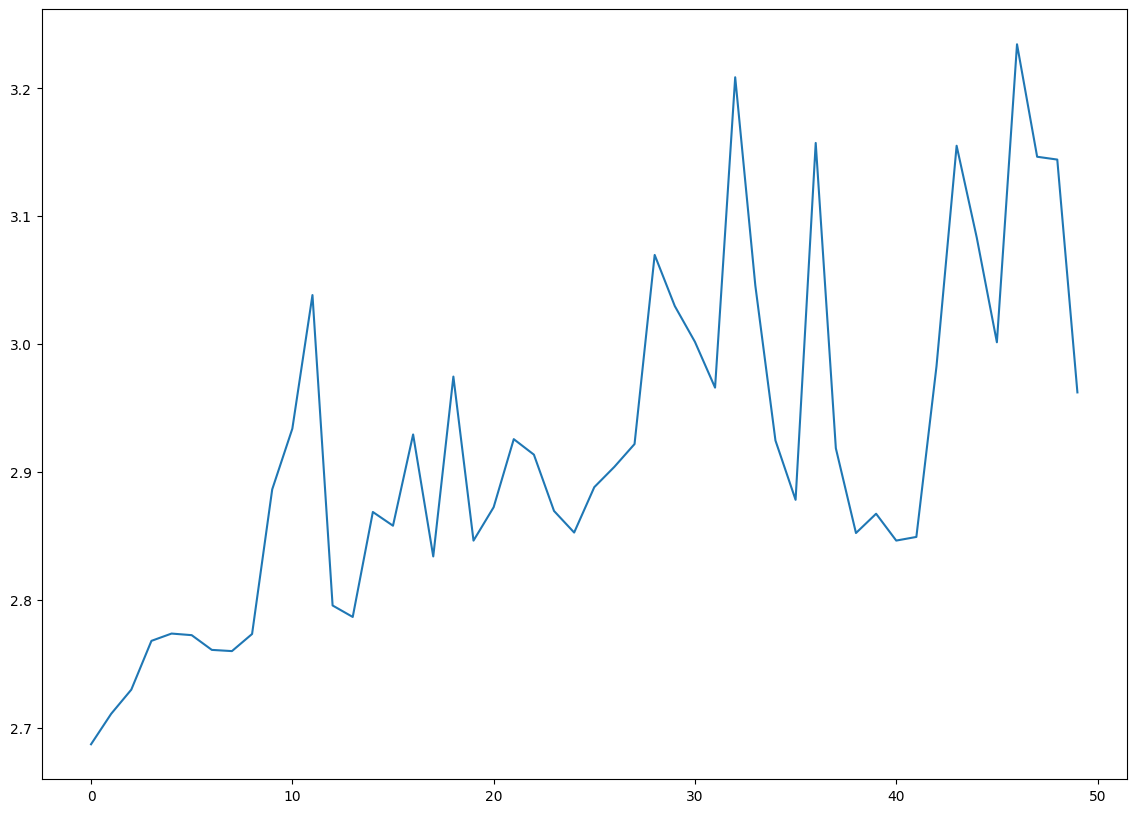

In [17]:
fig, arr = plt.subplots(1,1,figsize=(14,10))

losses = ESM_BIF["sgld_loss/trace"]
arr.plot(np.arange(losses.shape[1]), losses[0])
plt.show()

## Visualizations

In [18]:
computed_influences = ESM_BIF["BIF"].squeeze(-1)

TEST_TOKEN=3


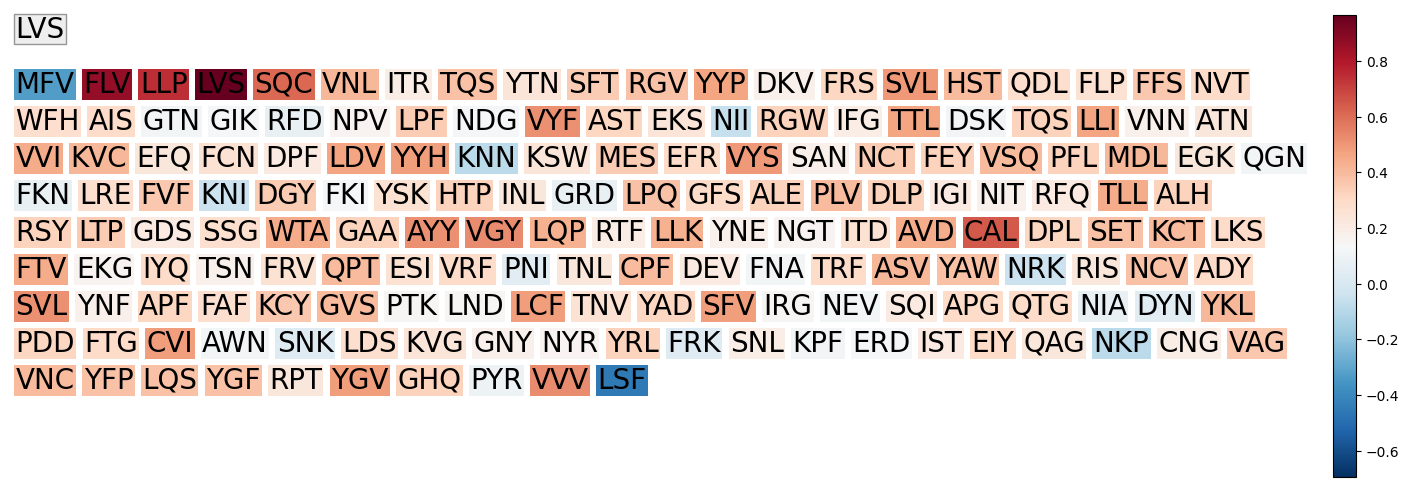

In [19]:
disp_BIF_influence(test_seq_disp, computed_influences, TEST_TOKEN=TEST_TOKEN)